In [55]:
#importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import warnings
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import BorderlineSMOTE
from geopy.distance import geodesic
import seaborn as sns
from math import fabs
from statsmodels.stats.outliers_influence import variance_inflation_factor
warnings.filterwarnings("ignore")

In [56]:
#loading the combined texas roadhouse and census data
df = pd.read_csv("trhCensusDf_updated.csv")

In [57]:
#computing a success metric, performing feature engineering and placing income in bins for easier analysis.
m = 50
C = df['rating'].mean()
df['successMetric'] = (df['totalUserRatings'] * df['rating'] + m * C) / (df['totalUserRatings'] + m)
threshold = np.percentile(df['successMetric'], 75)
df['success'] = np.where(df['successMetric'] > threshold, 1, 0)
df['incomeRentRatio'] = df['medianHouseholdIncome'] / (df['medianGrossRent'] + 1e-6)
df['povertyRatio'] = df['populationBelowPoverty'] / (df['totalPopulation'] + 1e-6)
binner = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
df['incomeBins'] = binner.fit_transform(df[['medianHouseholdIncome']])

In [58]:
#dropping the state columns
df = df.drop(['state_x', 'state_y'], axis=1)

In [59]:
#defining features relevant to our analysis (xSimp and x) and the target variable (y)
relevantFeatures = ['totalPopulation', 'malePopulation', 'femalePopulation', 'medianAge', 'medianAgeMale', 'medianAgeFemale', 'whitePopulation', 'blackPopulation', 'asianPopulation',
                  'hispanicPopulation', 'medianHouseholdIncome', 'perCapitaIncome', 'populationBelowPoverty', 'medianGrossRent', 'incomeBelow10k', 'income10kTo15k', 'income15kTo25k',
                  'totalHousingUnits', 'ownerOccupiedHousingUnits', 'renterOccupiedHousingUnits', 'medianHomeValue', 'medianMonthlyHousingCosts', 'medianYearStructureBuilt',
                  'totalEducationPopulation', 'bachelorsDegree', 'mastersDegree', 'doctorateDegree', 'employedPopulation', 'occupationData', 'managementOccupation', 'serviceOccupation',
                  'foreignBornPopulation', 'notHispanicWhitePopulation', 'notHispanicBlackPopulation', 'commuters', 'meanTravelTime', 'carAvailability', 'disabilityPopulation',
                  'healthInsurancePopulation', 'householdPopulation', 'singleParentHouseholds', 'marriedPopulation',  'incomeRentRatio', 'povertyRatio', 'incomeBins']
#defining xSimp for logistic regression model and x for gradient boosting model.
xSimp = df[relevantFeatures]
x = df.drop(columns=['name', 'address', 'city', 'placeName', 'successMetric', 'success', 'rating', 'totalUserRatings', 'placeID'])
y = df['success']

In [60]:
#calculating vif to identify and drop features where vif is greater than 10, as this signals high multicolinearity
vifData = pd.DataFrame()
vifData['feature'] = xSimp.columns
vifData['vif'] = [variance_inflation_factor(xSimp.values, i) for i in range(xSimp.shape[1])]
xSimpHighVIF = vifData[vifData['vif'] > 10]['feature'].tolist()
xSimp = xSimp.drop(columns=xSimpHighVIF)

In [61]:
#dropping the geometry column from x
x = x.drop(['geometry'], axis=1)

In [62]:
#preparing xSimp for logistic regression by encoding varibles and normalizing data.
xSimp = pd.get_dummies(xSimp, drop_first=True)
x = pd.get_dummies(x, drop_first=True)
xSimp = xSimp.apply(lambda col: (col - col.mean()) / col.std())

In [63]:
#removing columns where all rows have the same value.
for df in [xSimp, x]:
    constantColumns = [col for col in df.columns if df[col].nunique() == 1]
    if constantColumns:
        df.drop(columns=constantColumns, inplace=True)

In [64]:
#defining smote.
smote = BorderlineSMOTE(random_state=42, k_neighbors=2)

In [65]:
#conducting train test splits for both the logistic regression and gradient boosting models
xSimpBalanced, yBalanced = smote.fit_resample(xSimp, y)
xBalanced, yBalanced = smote.fit_resample(x, y)
xTrainSimp, xTestSimp, yTrain, yTest = train_test_split(xSimpBalanced, yBalanced, test_size=0.3, random_state=42)
xTrain, xTest, yTrain, yTest = train_test_split(xBalanced, yBalanced, test_size=0.3, random_state=42)

In [66]:
#training logistic regression baseline
logReg = LogisticRegression(max_iter=1000, random_state=38)
logReg.fit(xTrainSimp, yTrain)
yPredLogReg = logReg.predict(xTestSimp)

In [67]:
#training a fine-tuned gradient boosting model.
tunedGradBoost = GradientBoostingClassifier(learning_rate=0.1, max_depth=5, n_estimators=200, random_state=38)
tunedGradBoost.fit(xTrain, yTrain)
yPredTunedGradBoost = tunedGradBoost.predict(xTest)

In [68]:
#performing cross validation on the gradient boosting model and print the average f1 score.
stratifiedKFold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
crossValF1 = cross_val_score(tunedGradBoost, xTrain, yTrain, cv=stratifiedKFold, scoring='f1_weighted')

In [69]:
#printing metrics for logReg, gb, and cross val.
print(f"LOGISTIC REGRESSION BASE LINE MODEL: Accuracy: {accuracy_score(yTest, yPredLogReg):.4f}, Precision: {precision_score(yTest, yPredLogReg):.4f}, Recall: {recall_score(yTest, yPredLogReg):.4f}, F1 Score: {f1_score(yTest, yPredLogReg):.4f}")
print(f"GRADIENT BOOSTING FINE-TUNED MODEL : Accuracy: {accuracy_score(yTest, yPredTunedGradBoost):.4f}, Precision: {precision_score(yTest, yPredTunedGradBoost):.4f}, Recall: {recall_score(yTest, yPredTunedGradBoost):.4f}, F1 Score: {f1_score(yTest, yPredTunedGradBoost):.4f}")
print(f"CROSS VALIDATION MAE FOR EACH FOLD : {[f'{mae:.4f}' for mae in crossValF1]}")
print(f"AVERAGE CROSS VAL MAE FOR ALL FOLDS: {np.mean(crossValF1):.4f}")

LOGISTIC REGRESSION BASE LINE MODEL: Accuracy: 0.4758, Precision: 0.4758, Recall: 1.0000, F1 Score: 0.6448
GRADIENT BOOSTING FINE-TUNED MODEL : Accuracy: 0.8290, Precision: 0.8015, Recall: 0.8516, F1 Score: 0.8258
CROSS VALIDATION MAE FOR EACH FOLD : ['0.8332', '0.8008', '0.8638', '0.7999', '0.8559']
AVERAGE CROSS VAL MAE FOR ALL FOLDS: 0.8307


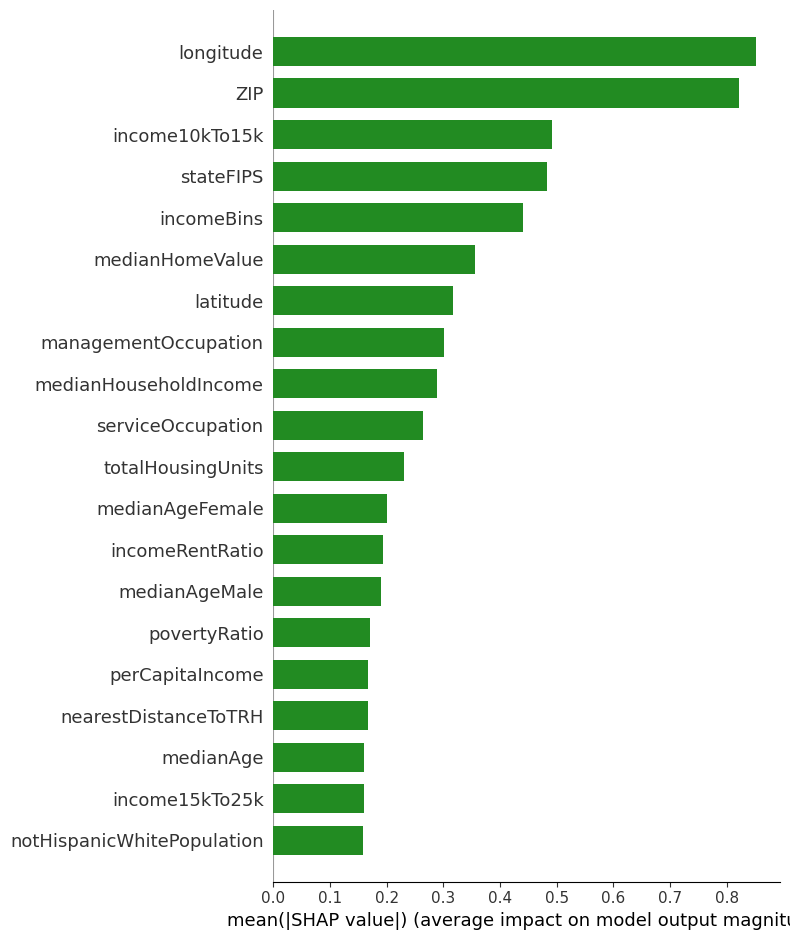

In [70]:
#performing SHAP analysis to understand which features contributed most to the predictions
explainer = shap.TreeExplainer(tunedGradBoost)
shapValues = explainer.shap_values(xTest)
shap.summary_plot(shapValues, xTest, plot_type="bar", color='#228B22')

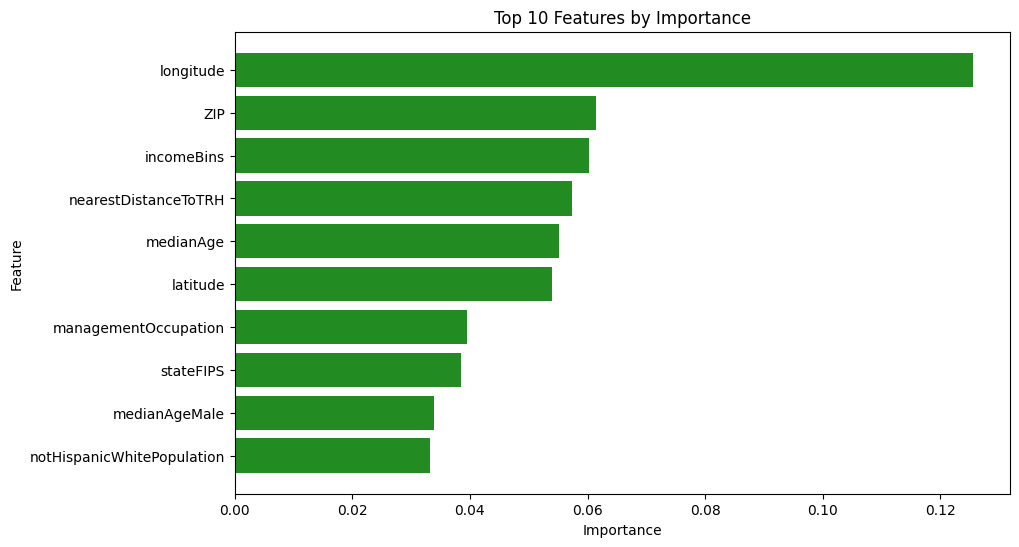

In [71]:
#plotting a bar chart to analyze feature importance.
importanceDf = pd.DataFrame({'Feature': x.columns, 'Importance': tunedGradBoost.feature_importances_}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(importanceDf["Feature"].head(10), importanceDf["Importance"].head(10), color="#228B22")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 10 Features by Importance")
plt.gca().invert_yaxis()
plt.show()

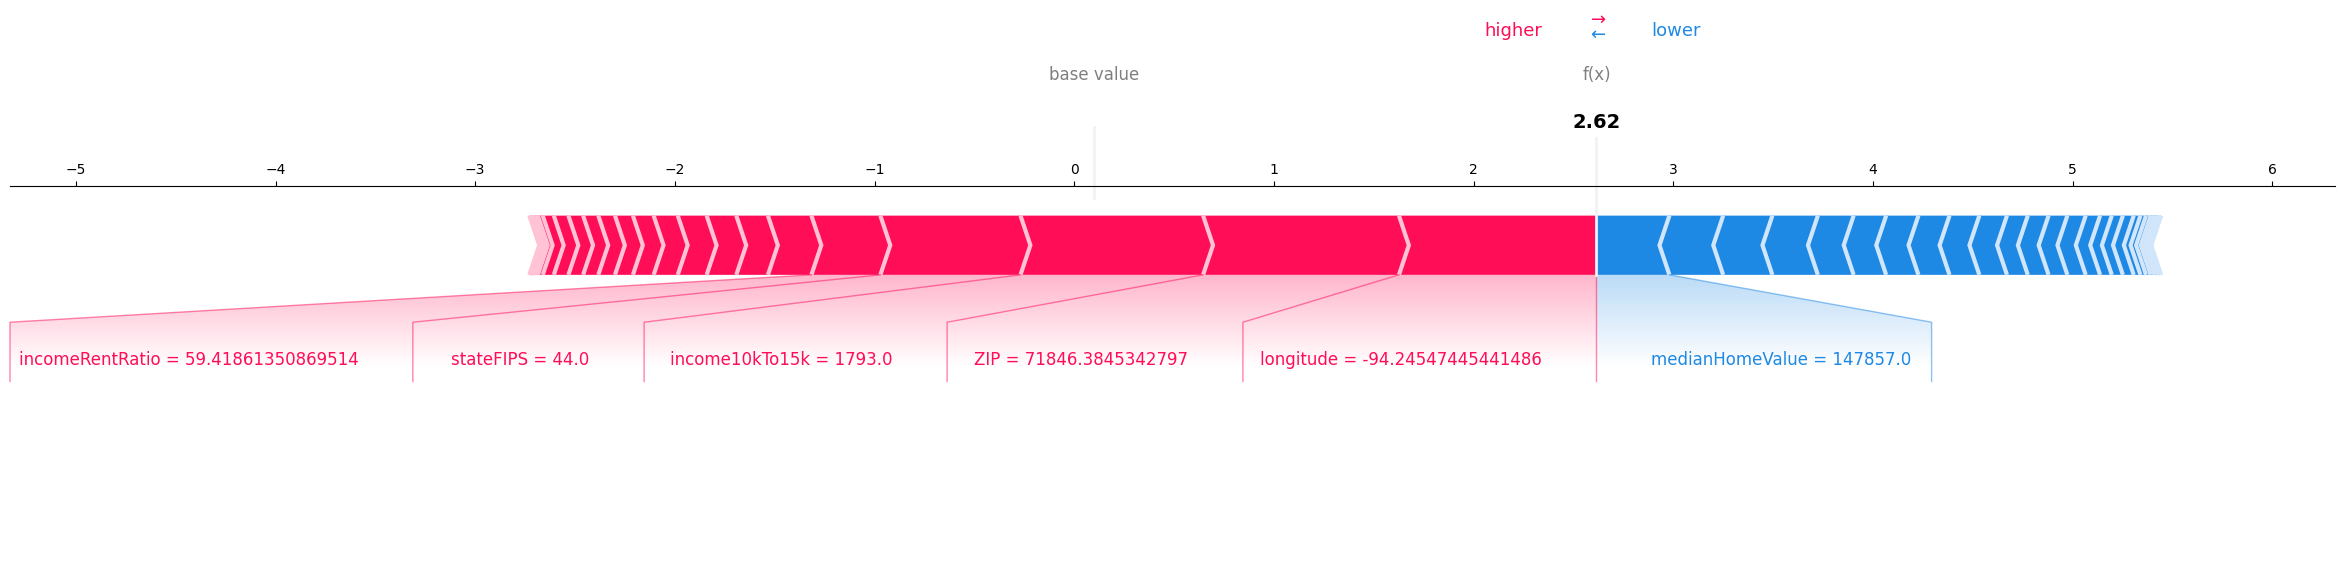

In [72]:
#creating force plot for SHAP interpretation
#performing SHAP analysis to understand which features contributed most to the predictions
explainer = shap.TreeExplainer(tunedGradBoost)
shapValues = explainer.shap_values(xTest)
shap.force_plot(explainer.expected_value, shapValues[0], xTest.iloc[0, :], matplotlib=True, figsize=(30,5))

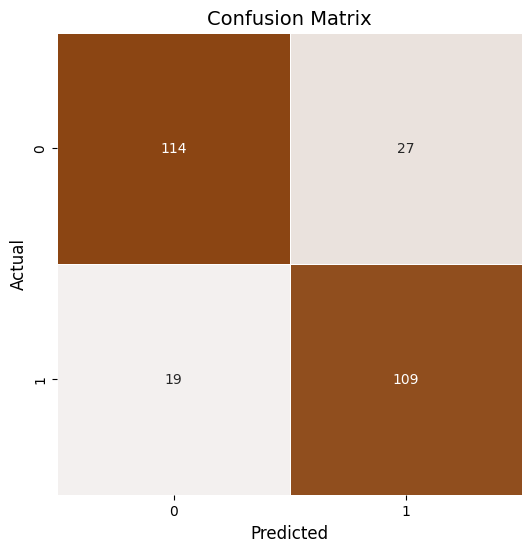

In [73]:
#plotting a confusion matrix to visualize predictions.
confMat = confusion_matrix(yTest, yPredTunedGradBoost)
plt.figure(figsize=(6, 6))
sns.heatmap(confMat, annot=True, fmt='d', cmap=sns.light_palette("#8B4513", as_cmap=True), cbar=False, linewidths=0.5)
plt.title("Confusion Matrix", fontsize=14)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.show()

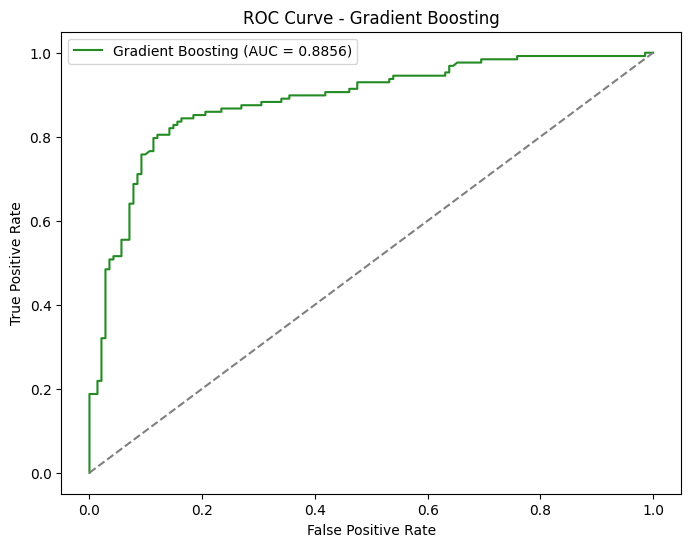

In [74]:
#plotting an ROC curve to show the model's ability to classify negative and positive outcomes.
#calculating the area under curve score for the gradient boosting model.
fpr, tpr, _ = roc_curve(yTest, tunedGradBoost.predict_proba(xTest)[:, 1])
aucScore = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="#228B22", label=f"Gradient Boosting (AUC = {aucScore:.4f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Gradient Boosting")
plt.legend()
plt.show()

In [75]:
#loading data
df1 = pd.read_csv("trhCensusDf_updated.csv")
df2 = pd.read_csv("updatedLocationResearch.csv")

In [76]:
#dropping 'state' and 'unmarriedPartners' and renaming the zip code column.
df2 = df2.drop(columns=['state', 'unmarriedPartners', 'address', 'placeName', 'geometry'], errors='ignore')
df2 = df2.rename(columns={'zip': 'ZIP'})

In [77]:
#converting latitude and longitude to numeric values
df1['latitude'] = pd.to_numeric(df1['latitude'], errors='coerce')
df1['longitude'] = pd.to_numeric(df1['longitude'], errors='coerce')
df2['latitude'] = pd.to_numeric(df2['latitude'], errors='coerce')
df2['longitude'] = pd.to_numeric(df2['longitude'], errors='coerce')

In [78]:
#defining a function to calculate the distance to the nearest TRH restaurant and calculating the distances
def calculateNearestDistance(lat, lon, trhLocations):
    if pd.isnull(lat) or pd.isnull(lon):
        return None
    distances = [fabs(geodesic((lat, lon), (trhLat, trhLon)).miles)
        for trhLat, trhLon in zip(trhLocations['latitude'], trhLocations['longitude'])]
    return min(distances) if distances else None
df2['nearestDistanceToTRH'] = df2.apply(lambda row: calculateNearestDistance(row['latitude'], row['longitude'], df1), axis=1)

In [79]:
#conducting feature engineering for df2 the same as training data for the fine tuned gb model
df2['incomeRentRatio'] = df2['medianHouseholdIncome'] / (df2['medianGrossRent'] + 1e-6)
df2['povertyRatio'] = df2['populationBelowPoverty'] / (df2['totalPopulation'] + 1e-6)
binner = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
df2['incomeBins'] = binner.fit_transform(df2[['medianHouseholdIncome']])

In [80]:
#creating a dataset to house 'city' and dropping 'city' and 'placeName' for preprocessing
df2_place_city = df2[['city']].copy()
df2 = df2.drop(columns=['placeName', 'city'], errors='ignore')

In [81]:
#encoding categorical columns in df2 and reordering to match columns in xTrain
df2 = pd.get_dummies(df2, drop_first=True)
df2 = df2[xTrain.columns]

In [82]:
#predicting the probability of success using the tuned gb model and adding labels based on predictions
df2['successProbability'] = tunedGradBoost.predict_proba(df2)[:, 1]
df2['predictedLabel'] = np.where(df2['successProbability'] > 0.5, "Likely Successful", "Unlikely Successful")

In [83]:
#reattaching the city name to df2 and saving predictions.
df2[['city']] = df2_place_city
df2.to_csv("predictedTRHLocations.csv", index=False)

In [84]:
#mapping FIPS values to states and applying the mapping to df2
stateFIPSMapping = {8: "CO", 16: "ID", 30: "MT", 45: "SC", 49: "UT"}
df2["state"] = df2["stateFIPS"].map(stateFIPSMapping).fillna("UK")

In [85]:
#adding columns relevant to one dataset to the other dataset, and filling them with 0
df2["successMetric"] = 0
df2["success"] = 0
df2["ratings"] = 0
df2["totalUserRatings"] = 0
df1["successProbability"] = 0
df1["predictedLabel"] = 0
#creating a new column to decipher between existing and potential locations
df2["existingLocation"] = 0
df1["existingLocation"] = 1

In [86]:
#aligning columns in df1 and df2 as a best practice before concatenation
commonColumns = [col for col in df1.columns if col in df2.columns]
df1 = df1[commonColumns]
df2 = df2[commonColumns]

In [87]:
#concatenating the existing and predicting datasets and saving them to a csv file for use in Tableau
combinedTRHLocations = pd.concat([df1, df2], ignore_index=True)
combinedTRHLocations.to_csv("combinedTRHLocations.csv", index=False)